**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [11]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from scipy import spatial
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [12]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.neighb = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.features = X
        self.target = y
        if(self.algorithm == 'kd_tree'):
            self.tree = KDTree(self.features, leaf_size = 30)
    
    def predict(self, X, metric='minkowski', p=2):
        X_standartized = X
        if(self.algorithm == 'brute'):
            if(metric=='minkowski'):
                result = np.argpartition(euclidean_distances(X_standartized, self.features),self.neighb, axis=1)[:,:self.neighb]
                return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, self.target[result])
            elif(metric=='cosine'):
                result = np.argpartition(cosine_distances(X_standartized, self.features),self.neighb, axis=1)[:,:self.neighb]
                return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, self.target[result])
        elif(self.algorithm == 'kd_tree'):
            ind = self.tree.query(X_standartized,k=self.neighb, return_distance=False)
            return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, self.target[ind])


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [13]:
iris = datasets.load_iris()

In [14]:
iris.data = (iris.data - np.mean(iris.data, axis=0)) / np.std(iris.data, axis=0) #standartisation

In [20]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [17]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
print('My own knn score = ', accuracy_score(y_test,my_clf_pred))
print('Sklearn knn score = ', accuracy_score(y_test, sklearn_pred))
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

My own knn score =  0.8666666666666667
Sklearn knn score =  0.8666666666666667


In [19]:
#counting mean score of my knn and sklearn knn
my_score = 0
sklearn_score = 0
n = 10000
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    my_score += accuracy_score(y_test, my_clf_pred)
    sklearn_score += accuracy_score(y_test, sklearn_pred)
print('My own mean knn score = ', my_score / n)
print('Sklearn mean knn score = ', sklearn_score / n)
assert abs((my_score - sklearn_score)/10000) <0.005, "Score must be simillar"

My own mean knn score =  0.9473266666666521
Sklearn mean knn score =  0.9473266666666521


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [21]:
%time clf.fit(X_train, y_train)

Wall time: 957 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [22]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [23]:
%time clf.predict(X_test)

Wall time: 2 ms


array([2, 0, 0, 2, 1, 1, 0, 1, 1, 2, 1, 1, 0, 2, 0])

In [24]:
%time my_clf.predict(X_test)

Wall time: 965 µs


array([2, 0, 0, 2, 1, 1, 0, 1, 1, 2, 1, 1, 0, 2, 0], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [25]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [27]:
%time clf.fit(X_train, y_train)

Wall time: 3.99 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [28]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [29]:
%time clf.predict(X_test)

Wall time: 2 ms


array([1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 2, 2])

In [30]:
%time my_clf.predict(X_test)

Wall time: 997 µs


array([1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 2, 2], dtype=int64)

In [31]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
print('My own knn score = ', accuracy_score(y_test,my_clf_pred))
print('Sklearn knn score = ', accuracy_score(y_test, sklearn_pred))
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

My own knn score =  1.0
Sklearn knn score =  1.0


In [32]:
#counting mean score of my knn and sklearn knn
my_score = 0
sklearn_score = 0
n = 10000
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    clf.predict(X_test)
    my_clf.predict(X_test)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    my_score += accuracy_score(y_test, my_clf_pred)
    sklearn_score += accuracy_score(y_test, sklearn_pred)
print('My own mean knn score = ', my_score / n)
print('Sklearn mean knn score = ', sklearn_score / n)
assert abs((my_score - sklearn_score)/10000) <0.005, "Score must be simillar"

My own mean knn score =  0.9468933333333173
Sklearn mean knn score =  0.9468933333333173


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [146]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [147]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [148]:
vectorizer = CountVectorizer(max_df=0.4)

In [149]:
text_matrix = vectorizer.fit_transform(data)

In [150]:
text_matrix.shape

(11314, 101615)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [70]:
cv = KFold(n_splits=3)

In [71]:
part = cv.split(target)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [151]:
def cv_score(data, target, clf_metric='minkowski', p=2, n=20):
    cv = KFold(n_splits=3)
    result = []
    for n_neighb in range(n+1)[1:]:
        score = []
        for train_ind, test_ind in cv.split(target):
            clf = MyKNeighborsClassifier(n_neighb, algorithm='brute')
            X_train, X_test = data[train_ind], data[test_ind]
            y_train, y_test = target[train_ind], target[test_ind]
            clf.fit(X_train, y_train)
            score.append(accuracy_score(clf.predict(X_test, metric=clf_metric, p=2), y_test))
        result.append(np.asarray(score).mean())
        print('Iteration :' , n_neighb)
    return result

In [152]:
%time mink_score = cv_score(text_matrix, target)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 1min 15s


In [153]:
mink_score

[0.23448837329852323,
 0.19170957706948313,
 0.18711370443578879,
 0.18596472456025448,
 0.1900294840000041,
 0.18985276653638175,
 0.19215067941900754,
 0.19029485312320524,
 0.18870352888441203,
 0.187113024843368,
 0.18667079765121608,
 0.1856985352393042,
 0.18295884041473323,
 0.18481508852652084,
 0.18375476031056528,
 0.18313590939167668,
 0.18304746864009055,
 0.18030756290752695,
 0.17898170152882045,
 0.17853963837621842]

*Оптимальное число соседей:*

In [154]:
np.asarray(mink_score[1:]).argmax() + 2

7

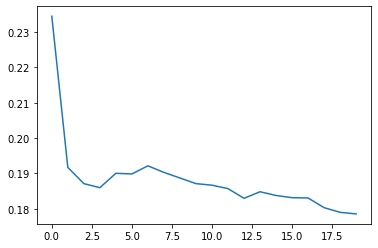

In [155]:
plt.plot(mink_score)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

*1. Косинусная метрика*

In [156]:
%time cosine_score = cv_score(text_matrix, target, clf_metric='cosine', n=20)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 1min 25s


In [157]:
cosine_score

[0.4305285241811638,
 0.4027753523358622,
 0.4012728906646404,
 0.4048080601348367,
 0.40975741456421866,
 0.412762384775105,
 0.41311593687345677,
 0.41205518684151593,
 0.4182421962402323,
 0.4173584683167921,
 0.4170051505606544,
 0.41780043773250847,
 0.41797748327523054,
 0.41841924178295437,
 0.4206287373482154,
 0.4228383735188049,
 0.4217777172237496,
 0.4198333564394756,
 0.4200987021284554,
 0.42001009733731937]

*Оптимальное число соседей:*

In [158]:
np.asarray(cosine_score[1:]).argmax() + 2

16

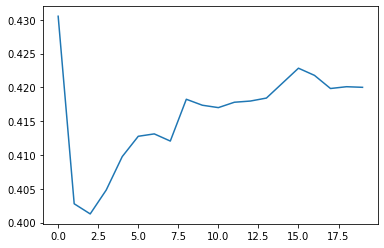

In [159]:
plt.plot(cosine_score)

*2. Tfidf векторизация*

In [160]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5)

In [161]:
tfidf_matrix = tfidf_vectorizer.fit_transform(data)

*2.1 Tfidf векторизация и евклидова метрика*

In [162]:
%time tfidf_mink_score = cv_score(tfidf_matrix, target, n=20)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 1min 26s


In [163]:
tfidf_mink_score

[0.13505399572691035,
 0.08211121525279104,
 0.09033058093716075,
 0.08617597469254068,
 0.08317069983677595,
 0.08325921089102628,
 0.08166823816555414,
 0.07857489750574582,
 0.07795651527128533,
 0.07592387777497504,
 0.0750396577328853,
 0.0748627527954917,
 0.07477433547812702,
 0.0735368445483424,
 0.0746858712923195,
 0.07327187380690521,
 0.0722113112487356,
 0.07282997469385298,
 0.0706204088259277,
 0.0704435038885341]

*Оптимальное число соседей:*

In [164]:
np.asarray(tfidf_mink_score)[1:].argmax() + 2

3

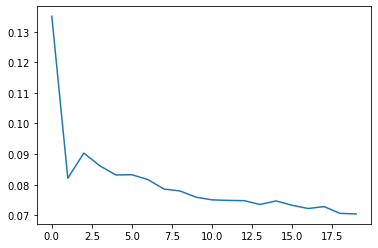

In [165]:
plt.plot(tfidf_mink_score)

*2.2 Tfidf векторизация и косинусная метрика*

In [166]:
%time tfidf_cosine_score = cv_score(tfidf_matrix, target, clf_metric='cosine', n=20)

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Wall time: 1min 32s


In [167]:
tfidf_cosine_score

[0.622857444288185,
 0.5848501133138342,
 0.604825982627368,
 0.6142835422681645,
 0.6246245017533015,
 0.6258620629857504,
 0.6293974433639394,
 0.632490971497519,
 0.6334628589618884,
 0.6334626246196743,
 0.6346118857058655,
 0.6333744182103023,
 0.6341701037639202,
 0.6343466806222141,
 0.6339931988265267,
 0.6374403259269008,
 0.6374403024926795,
 0.6365565745692391,
 0.6362026943917877,
 0.6347885328668236]

*Оптимальное число соседей :*

In [168]:
np.asarray(tfidf_cosine_score)[1:].argmax() + 2

16

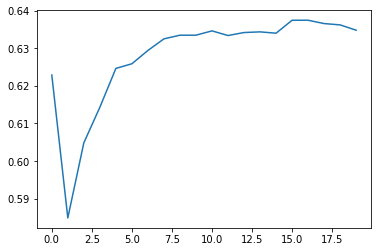

In [169]:
plt.plot(tfidf_cosine_score)

*Лучшая модель с использованием косинусной метрики и Tfidf векторизации b 16-ю соседями!*

*Качество с использованием косинусной метрики слегка улучшается, а с использованием Tfidf векторизации улучшается значительно*

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [177]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [178]:
test_data, test_target = newsgroups['data'], newsgroups['target']

In [179]:
test_matrix = tfidf_vectorizer.transform(test_data)

In [180]:
final_clf = MyKNeighborsClassifier(n_neighbors=16,algorithm='brute')

In [181]:
final_clf.fit(tfidf_matrix, target)

In [182]:
prediction = final_clf.predict(test_matrix, metric='cosine')

In [183]:
accuracy_score(prediction, test_target)

0.5799256505576208

Да, качество хуже, чем на кросс-валидации.
Вывод : тестовая выборка может быть не репрезентативной.